In [22]:
from dataclasses import dataclass
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

In [23]:
@dataclass
class TrainingConfig:
    learning_rate = 0.01
    n_episodes = 100_000
    start_epsilon = 1.0
    final_epsilon = 0.1
    discount_factor = 0.95

    @property
    def epsilon_decay(self) -> float:
        return self.start_epsilon / (self.n_episodes / 2)

In [24]:
class BlackjackAgent:
    # Tabular, model-free Q-learning agent (off-policy), epsilon-greedy
    def __init__(self, action_n, cfg: TrainingConfig):
        self.q_values = defaultdict(lambda: np.zeros(action_n))
        self.lr = cfg.learning_rate
        self.discount_factor = cfg.discount_factor

        self.epsilon = cfg.start_epsilon
        self.epsilon_decay = cfg.epsilon_decay
        self.final_epsilon = cfg.final_epsilon

        self.training_error = []

    def get_action(self, obs) -> int:
        if np.random.random() < self.epsilon:
            return int(np.random.randint(0, len(self.q_values[(0, 0, False)])))  # fallback shape
        return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs,
        action,
        reward,
        terminated,
        next_obs,
    ):
        future_q = (not terminated) * np.max(self.q_values[next_obs])
        td = reward + self.discount_factor * future_q - self.q_values[obs][action]
        self.q_values[obs][action] += self.lr * td
        self.training_error.append(float(td))

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [25]:
class MonteCarloAgent:
    def __init__(self, action_n, cfg: TrainingConfig):
        # Q estimate as average returns
        self.q_values = defaultdict(lambda: np.zeros(action_n))

        # Sum and count of returns for averaging
        self.returns_sum = defaultdict(lambda: np.zeros(action_n))
        self.returns_count = defaultdict(lambda: np.zeros(action_n))
        self.lr = None  # not used for MC but kept for similarity to the first Agent
        self.discount_factor = cfg.discount_factor

        self.epsilon = cfg.start_epsilon
        self.epsilon_decay = cfg.epsilon_decay
        self.final_epsilon = cfg.final_epsilon

        # buffer for the current episode: list of (obs, action, reward)
        self.episode = []
        self.training_error = []

    def get_action(self, obs) -> int:
        if np.random.random() < self.epsilon:
            return int(np.random.randint(0, len(self.q_values[(0, 0, False)])))
        return int(np.argmax(self.q_values[obs]))

    def update(self, obs, action, reward, terminated, next_obs):
        # buffer the step
        self.episode.append((obs, action, reward))

        if not terminated:
            return

        # episode finished: compute first-visit returns and update Q
        G = 0.0
        seen = set()
        # traverse backwards to compute discounted return G
        for state, act, rew in reversed(self.episode):
            G = rew + self.discount_factor * G
            key = (state, act)
            if key in seen:
                continue
            seen.add(key)

            # update sums/counts and compute new average
            self.returns_sum[state][act] += G
            self.returns_count[state][act] += 1.0
            new_q = self.returns_sum[state][act] / self.returns_count[state][act]
            old_q = self.q_values[state][act]
            self.q_values[state][act] = new_q

            # track change magnitude as training error
            self.training_error.append(float(abs(new_q - old_q)))

        # clear episode buffer
        self.episode.clear()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [26]:
def make_env(num_episodes):
    env = gym.make("Blackjack-v1", sab=True)
    return gym.wrappers.RecordEpisodeStatistics(env, buffer_length=num_episodes)

In [27]:
def train_agent(env, agent, cfg: TrainingConfig):
    for _ in tqdm(range(cfg.n_episodes)):
        obs, _ = env.reset()
        done = False
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            agent.update(obs, action, reward, terminated, next_obs)
            obs = next_obs
            done = terminated or truncated
        agent.decay_epsilon()

In [28]:
def moving_average(x, window, mode = "same"):
    return np.convolve(x, np.ones(window), mode=mode) / window

In [29]:
def plot_training(env, agent, rolling_length = 1000):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    rewards = np.array(env.return_queue).flatten()
    axs[0].plot(moving_average(rewards, rolling_length, mode="valid"))

    axs[1].set_title("Episode lengths")
    lengths = np.array(env.length_queue).flatten()
    axs[1].plot(moving_average(lengths, rolling_length, mode="same"))

    axs[2].set_title("Training Error")
    errs = np.array(agent.training_error)
    axs[2].plot(moving_average(errs, rolling_length, mode="same"))

    plt.tight_layout()
    plt.show()

In [30]:
def create_grids(agent: BlackjackAgent, usable_ace = False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11))

    value = np.apply_along_axis(
        lambda o: state_value[(int(o[0]), int(o[1]), usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )

    policy_grid = np.apply_along_axis(
        lambda o: policy[(int(o[0]), int(o[1]), usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )

    return (player_count, dealer_count, value), policy_grid

In [31]:
def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(player_count, dealer_count, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False, ax=ax2)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

100%|██████████| 100000/100000 [00:12<00:00, 8064.03it/s]


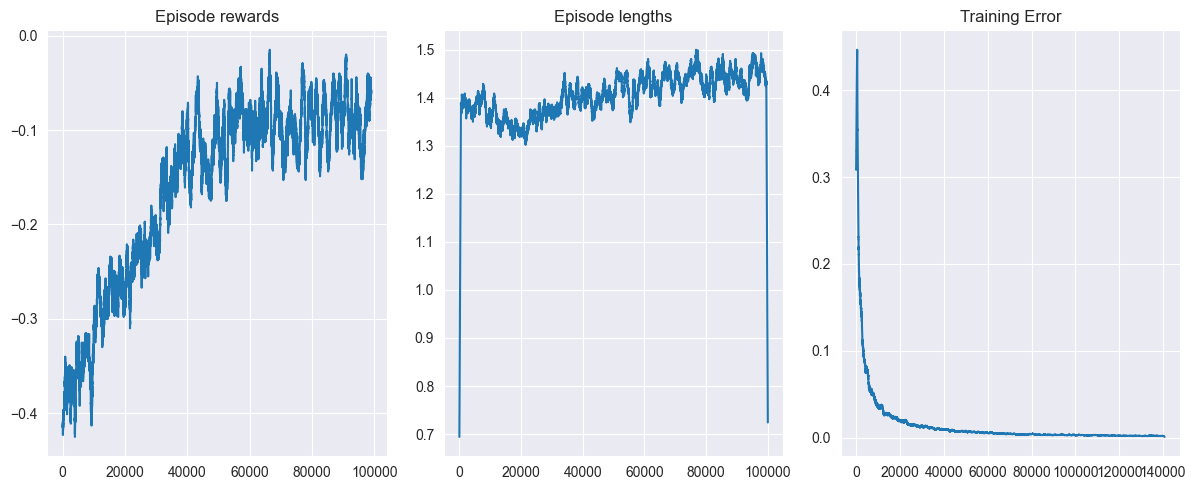

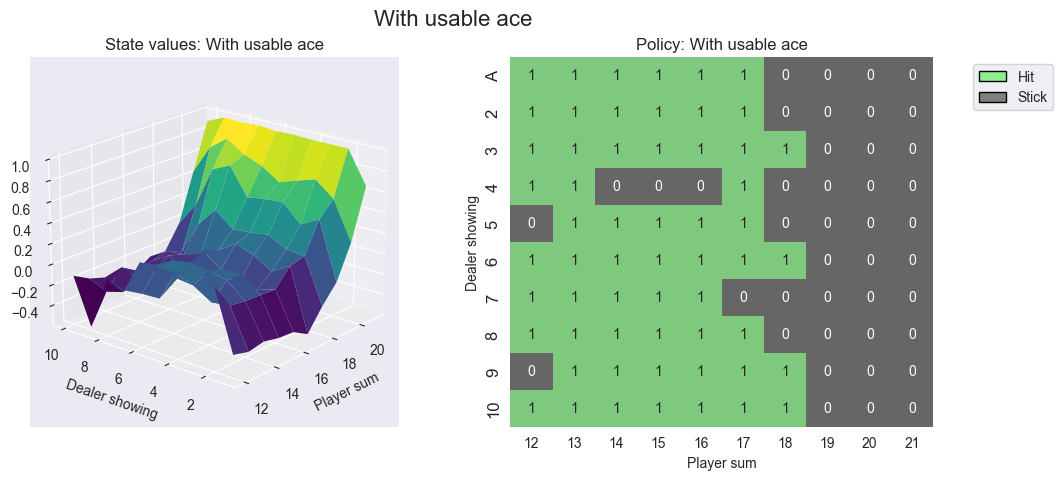

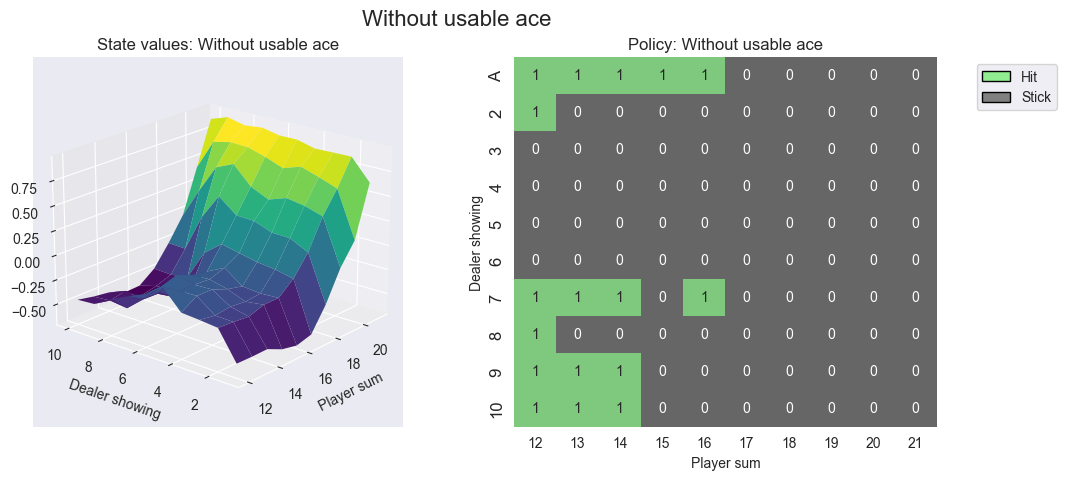

In [32]:
cfg = TrainingConfig()
env = make_env(cfg.n_episodes)
# agent = BlackjackAgent(action_n=env.action_space.n, cfg=cfg)
agent2 = MonteCarloAgent(action_n=env.action_space.n, cfg=cfg)

# train_agent(env, agent, cfg)
train_agent(env, agent2, cfg)

# plot_training(env, agent)
plot_training(env, agent2)

# v_g, p_g = create_grids(agent, usable_ace=True)
v_g, p_g = create_grids(agent2, usable_ace=True)
create_plots(v_g, p_g, "With usable ace")
plt.show()

# v_g, p_g = create_grids(agent, usable_ace=False)
v_g, p_g = create_grids(agent2, usable_ace=False)
create_plots(v_g, p_g, "Without usable ace")
plt.show()